In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from os import listdir
from os.path import isfile, isdir
from math import factorial

plt.rcParams.update({'font.size': 15})
y = 5
eq_energy = 0.2
protein_name = '1PGB'

In [111]:
## Load parameters
def load_parameters(d):
    with open(f'{d}/parameters.dat', 'r') as f:
        lines = f.readlines()
    splitted_lines = np.array([line.split('\t') for line in lines])
    parameters = {
            'generation': splitted_lines[:, 0].astype(int),
            'T': splitted_lines[:, 1].astype(float),
            'gamma': splitted_lines[:, 2].astype(float),
            'y': splitted_lines[:, 3].astype(int),
            'seed': splitted_lines[:, 4].astype(int),
            'acceptance_rate': splitted_lines[:, 5].astype(float)
    }
    assert len(np.unique(parameters['y'])) == 1, 'Too many saved values for y replica value.'
    return parameters


## Load single replica data
def load_replica(d, replica_idx, y):
    replica_file = np.array([f for f in listdir(d) if isfile(f'{d}/{f}') and (f'replica_{replica_idx}.dat' == f)])
    assert len(replica_file) == 1, 'Too many replica files for the same replica.'
    replica_file = replica_file[0]
    
    with open(f'{d}/{replica_file}', 'r') as f:
        lines = f.readlines()
    splitted_lines = np.array([line.split('\t') for line in lines])
    sequences = splitted_lines[:, 1]
    energies = splitted_lines[:, 2].astype(float)
    Hamm_distances = splitted_lines[:, (3+y):(3+2*y)].astype(float)
    PAM1_distances = splitted_lines[:, 3:(3+y)].astype(float)
    return sequences, energies, Hamm_distances, PAM1_distances


## Load all replicas data
def load_all(d):
    data = {
        'sequences': np.array([]),
        'energies': np.array([]),
        'Hamm_distances': np.array([]),
        'PAM1_distances': np.array([]),
    }
    parameters = load_parameters(d)
    y = np.unique(parameters['y'])
    assert len(y) == 1, 'Too many values for y parameter.'
    y = y[0]
    assert len([f for f in listdir(d) if isfile(f'{d}/{f}') and ('replica' in f)]) == y, 'Wrong number of replica files based on simulation parameter y.'
    
    for irep in range(y):
        replica_data = load_replica(d, irep, y)
        replica_data = list(replica_data)
        for i, key in enumerate(data):
            replica_data[i] = np.expand_dims(replica_data[i], axis = 1)
            if irep == 0:
                data[key] = replica_data[i].copy()
            else:
                data[key] = np.append(data[key], replica_data[i], axis = 1)
    return data

---
## Thermical equilibration

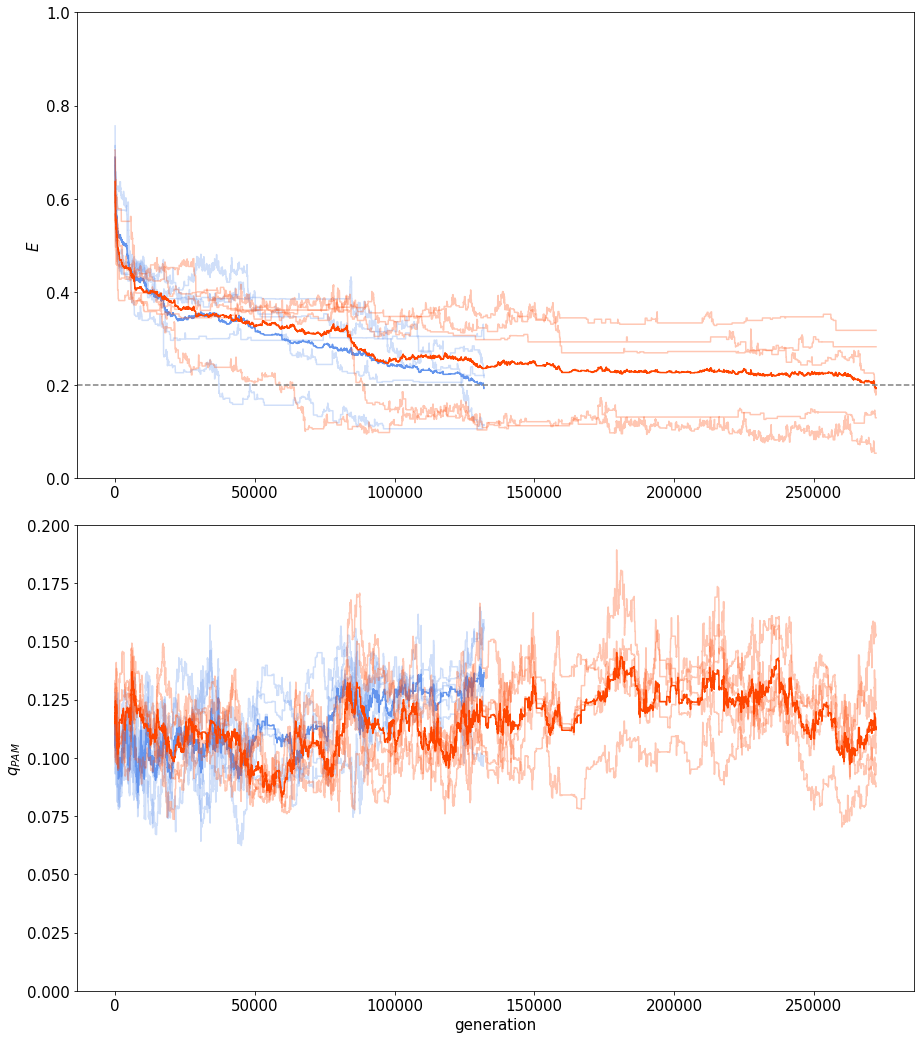

In [121]:
d_start = f'results/{protein_name}/NE'
colors = ['cornflowerblue', 'orangered']
dtype = 'PAM1'


fig = plt.figure(figsize = (15, 18))
ax_e = plt.subplot(2, 1, 1)
ax_q = plt.subplot(2, 1, 2)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d, color in zip(dirlist, colors):
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    assert len(sub_dirlist) == 1, 'Too many sub directories.'
    sub_d = sub_dirlist[0]
    actual_d = f'{d_start}/{d}/{sub_d}'
    parameters = load_parameters(actual_d)
    data = load_all(actual_d)
    
    mask = parameters['gamma'] == 0
    generations = parameters['generation'][mask]
    
    ax = ax_e
    for irep in range(y): 
        ax.plot(generations, data['energies'][mask, irep], color = color, alpha = 0.3)
    ax.plot(generations, data['energies'][mask].mean(axis = 1), color = color)
    
    ax = ax_q
    for irep in range(y):
        replica_mean_q = 1. - data[f'{dtype}_distances'][mask, irep].sum(axis = 1) / (y - 1)
        ax.plot(generations, replica_mean_q, color = color, alpha = 0.3)
    mean_q = 1. - (data[f'{dtype}_distances'][mask, :].sum(axis = 1) / (y - 1)).mean(axis = 1)
    ax.plot(generations, mean_q, color = color)
    
ax_e.axhline(eq_energy, linestyle = '--', color = 'grey')
ax_e.set_ylabel(r'$E$')
ax_e.set_ylim([0., 1.])

if dtype == 'PAM1': ax_q.set_ylabel(r'$q_{PAM}$')
elif dtype == 'Hamm': ax_q.set_ylabel(r'$q$')
ax_q.set_xlabel('generation');
ax_q.set_ylim([0., 0.2])

plt.subplots_adjust(hspace = 0.1);

---
## Non-zero gamma evolution

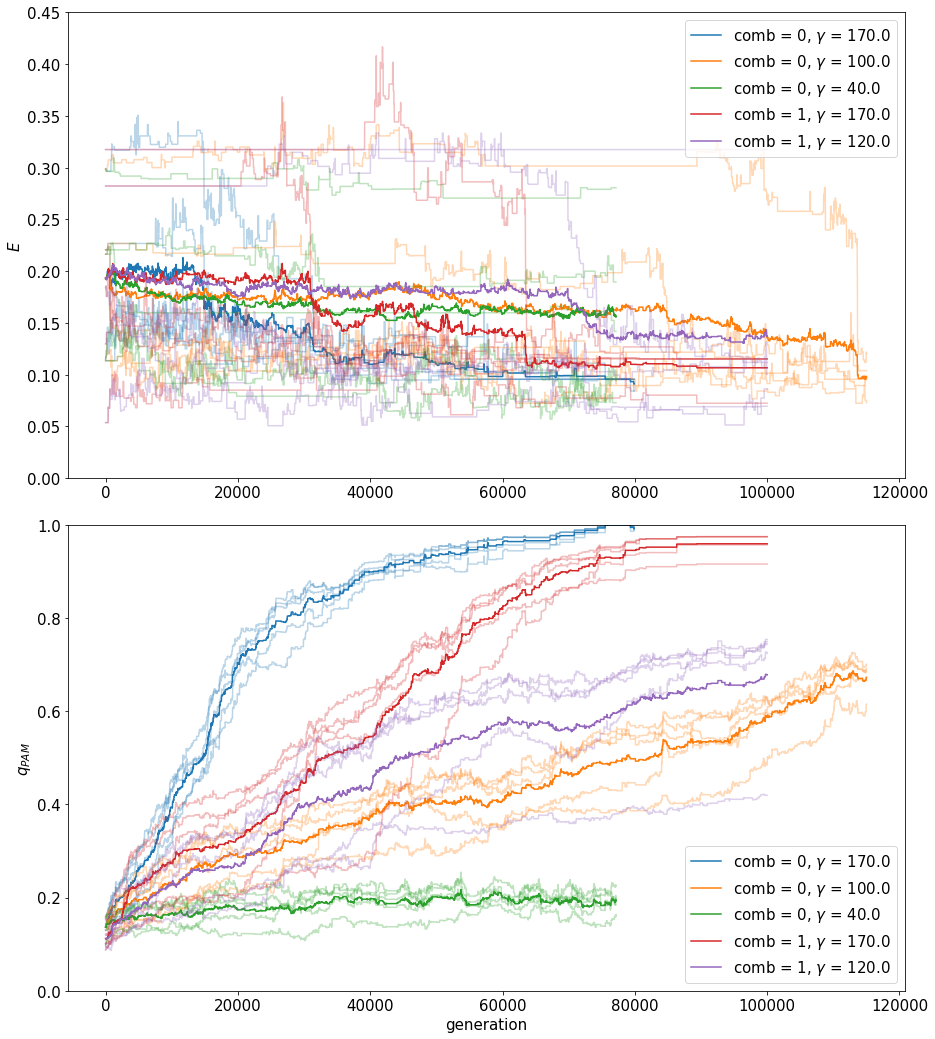

In [122]:
d_start = f'results/{protein_name}/NE'
dtype = 'PAM1'


fig = plt.figure(figsize = (15, 18))
ax_e = plt.subplot(2, 1, 1)
ax_q = plt.subplot(2, 1, 2)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        actual_d = f'{d_start}/{d}/{sub_d}'
        parameters = load_parameters(actual_d)
        data = load_all(actual_d)
        
        generations = parameters['generation']
        assert len(np.unique(parameters['gamma'])) == 1, r'Too many values for $\gamma$ parameter.'
        gamma = np.unique(parameters['gamma'])[0]
        label = f'comb = {comb}, ' + r'$\gamma$' + f' = {gamma}'

        ax = ax_e
        for irep in range(y):
            if irep == 0:
                ax.plot(generations, data['energies'][:, irep], alpha = 0.3)
                color = ax.get_lines()[-1].get_color()
            else:
                ax.plot(generations, data['energies'][:, irep], color = color, alpha = 0.3)
        ax.plot(generations, data['energies'].mean(axis = 1), color = color, label = label)

        ax = ax_q
        for irep in range(y):
            replica_mean_q = 1. - data[f'{dtype}_distances'][:, irep].sum(axis = 1) / (y - 1)
            ax.plot(generations, replica_mean_q, color = color, alpha = 0.3)
        mean_q = 1. - (data[f'{dtype}_distances'].sum(axis = 1) / (y - 1)).mean(axis = 1)
        ax.plot(generations, mean_q, color = color, label = label)
    
ax_e.set_ylabel(r'$E$')
ax_e.set_ylim([0., 0.45])
ax_e.legend()

if dtype == 'PAM1': ax_q.set_ylabel(r'$q_{PAM}$')
elif dtype == 'Hamm': ax_q.set_ylabel(r'$q$')
ax_q.set_xlabel('generation');
ax_q.set_ylim([0., 1.])
ax_q.legend()

plt.subplots_adjust(hspace = 0.1);

---
## Non-zero gamma p(q)

#### - Hamming q

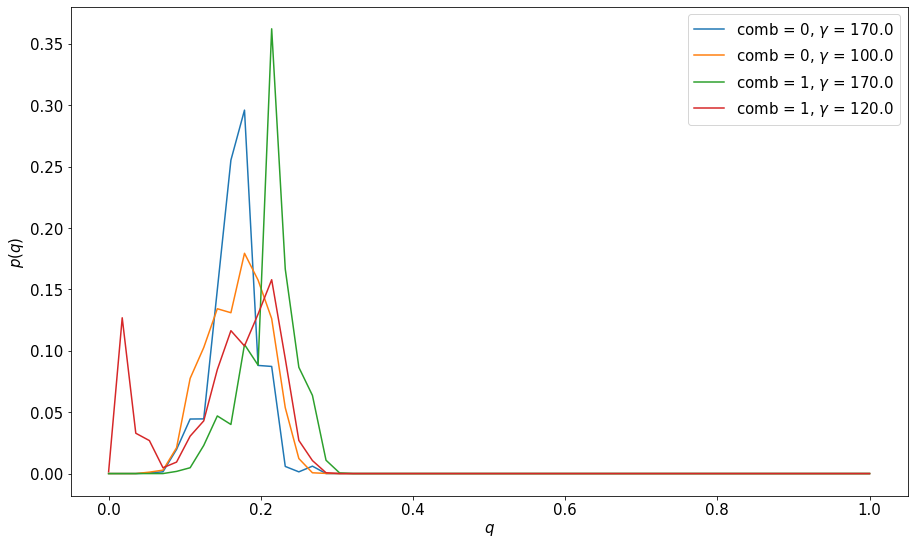

In [136]:
d_start = f'process/p_q/results/{protein_name}'
ptype = 'simple_ms'


fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        gamma = float(sub_d.split('_')[-1][1:])
        label = f'comb = {comb}, ' + r'$\gamma$' + f' = {gamma}'
        actual_d = f'{d_start}/{d}/{sub_d}'
        filelist = [f'{actual_d}/{f}' for f in listdir(f'{actual_d}') if isfile(f'{actual_d}/{f}') and (ptype in f)]
        assert len(filelist) == 1, 'Too many files with different p(q) calculation.'
        csv_file = filelist[0]
        
        df = pd.read_csv(csv_file)
        ax.plot(df['q'], df['pdf'], label = label)

ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$p(q)$')
ax.legend()

plt.subplots_adjust(hspace = 0.1);

#### - Hamming weighted q

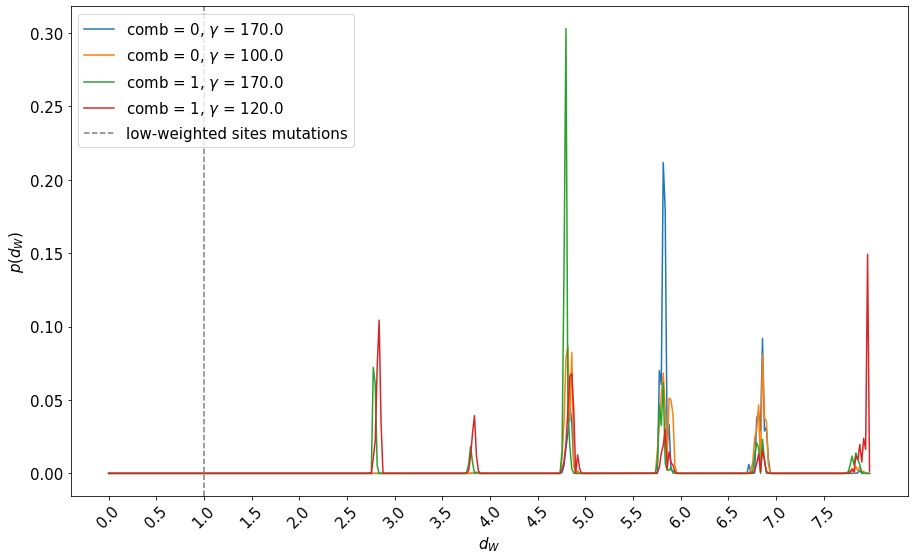

In [137]:
d_start = f'process/p_q/results/{protein_name}'
ptype = 'weighted_ms'


fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        gamma = float(sub_d.split('_')[-1][1:])
        label = f'comb = {comb}, ' + r'$\gamma$' + f' = {gamma}'
        actual_d = f'{d_start}/{d}/{sub_d}'
        filelist = [f'{actual_d}/{f}' for f in listdir(f'{actual_d}') if isfile(f'{actual_d}/{f}') and (ptype in f)]
        assert len(filelist) == 1, 'Too many files with different p(q) calculation.'
        csv_file = filelist[0]
        
        df = pd.read_csv(csv_file)
        ax.plot(df['d'], df['pdf'], label = label)
ax.axvline(x = 1., linestyle = '--', color = 'grey', label = 'low-weighted sites mutations')

xticks = np.arange(df['d'].max() / 0.5) * 0.5
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".1f") for xtick in xticks], rotation = 45)
ax.set_xlabel(r'$d_{W}$')
ax.set_ylabel(r'$p(d_{W})$')
ax.legend(loc = 'upper left')

plt.subplots_adjust(hspace = 0.1);

---
#### - Hamming q, 1PGB sequence

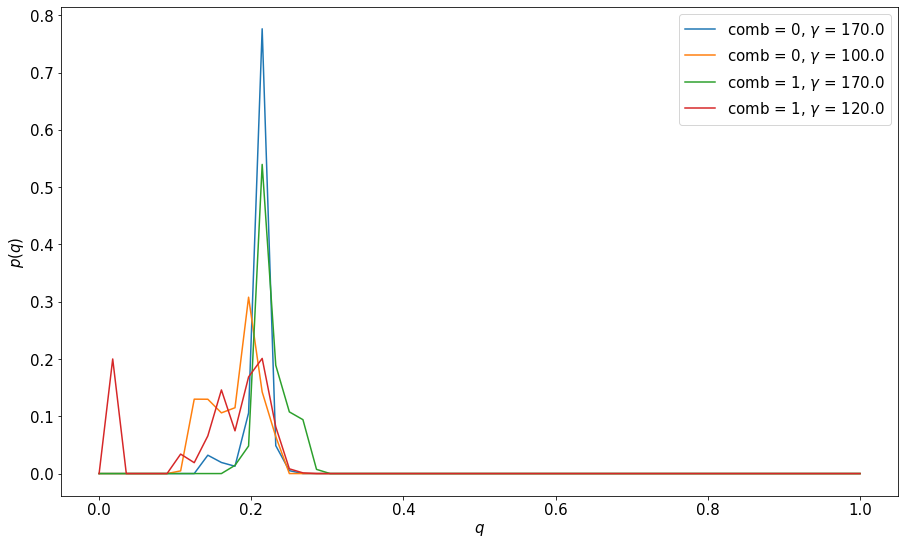

In [138]:
d_start = f'process/p_q/results/{protein_name}'
ptype = 'simple_ss'


fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        gamma = float(sub_d.split('_')[-1][1:])
        label = f'comb = {comb}, ' + r'$\gamma$' + f' = {gamma}'
        actual_d = f'{d_start}/{d}/{sub_d}'
        filelist = [f'{actual_d}/{f}' for f in listdir(f'{actual_d}') if isfile(f'{actual_d}/{f}') and (ptype in f)]
        assert len(filelist) == 1, 'Too many files with different p(q) calculation.'
        csv_file = filelist[0]
        
        df = pd.read_csv(csv_file)
        ax.plot(df['q'], df['pdf'], label = label)

ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$p(q)$')
ax.legend()

plt.subplots_adjust(hspace = 0.1);

#### - Hamming weighted q

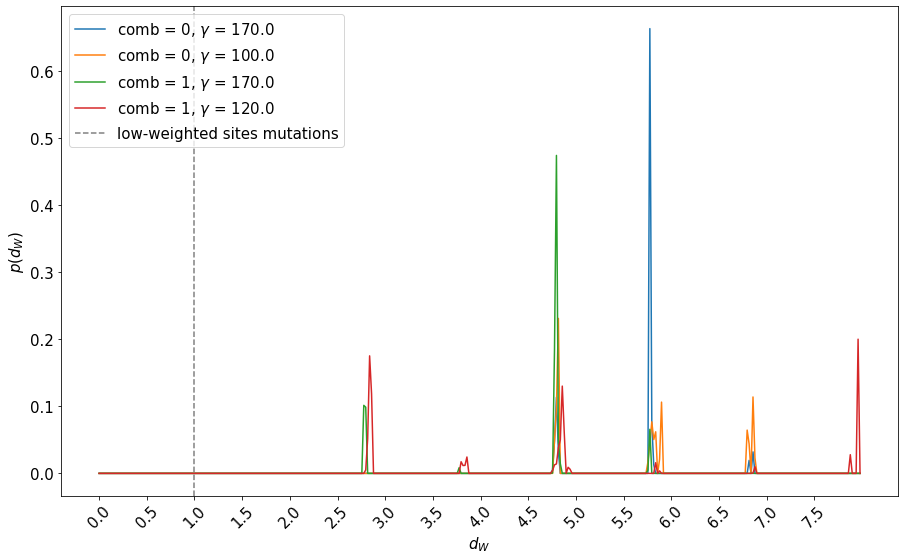

In [139]:
d_start = f'process/p_q/results/{protein_name}'
ptype = 'weighted_ss'


fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

dirlist = [d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    sub_dirlist = [sub_d for sub_d in listdir(f'{d_start}/{d}') 
                   if isdir(f'{d_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        gamma = float(sub_d.split('_')[-1][1:])
        label = f'comb = {comb}, ' + r'$\gamma$' + f' = {gamma}'
        actual_d = f'{d_start}/{d}/{sub_d}'
        filelist = [f'{actual_d}/{f}' for f in listdir(f'{actual_d}') if isfile(f'{actual_d}/{f}') and (ptype in f)]
        assert len(filelist) == 1, 'Too many files with different p(q) calculation.'
        csv_file = filelist[0]
        
        df = pd.read_csv(csv_file)
        ax.plot(df['d'], df['pdf'], label = label)
ax.axvline(x = 1., linestyle = '--', color = 'grey', label = 'low-weighted sites mutations')

xticks = np.arange(df['d'].max() / 0.5) * 0.5
ax.set_xticks(xticks)
ax.set_xticklabels([format(xtick, ".1f") for xtick in xticks], rotation = 45)
ax.set_xlabel(r'$d_{W}$')
ax.set_ylabel(r'$p(d_{W})$')
ax.legend(loc = 'upper left')

plt.subplots_adjust(hspace = 0.1);

In [147]:
site_weights = np.load('process/p_q/run/inputs/site_weights.npy')
mask = site_weights == 1.

In [165]:
pq_start = f'process/p_q/results/{protein_name}'
data_start = f'results/{protein_name}/AE'
ptype = 'weighted_ss'

reference = 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'  # 1PGB
reference_Ksites = np.array(list(reference_sequence))[mask]

print('Explored K-sites combination at each gamma (for comb = 1)\n')
dirlist = [d for d in listdir(f'{pq_start}') if isdir(f'{pq_start}/{d}') and (not '.ipynb' in d)]
for d in dirlist:
    comb = int(d.split('_')[-1][1:])
    if comb != 1: continue
    sub_dirlist = [sub_d for sub_d in listdir(f'{pq_start}/{d}') 
                   if isdir(f'{pq_start}/{d}/{sub_d}') and (not '.ipynb' in sub_d)]
    for sub_d in sub_dirlist:
        gamma = float(sub_d.split('_')[-1][1:])
        filelist = [f for f in listdir(f'{pq_start}/{d}/{sub_d}') if isfile(f'{pq_start}/{d}/{sub_d}/{f}') and (ptype in f)]
        assert len(filelist) == 1, 'Too many files with different p(q) calculation.'
        discarded_mutations = int(filelist[0].split('_')[-1][2:-4])
        
        actual_d = f'{data_start}/{d}/{sub_d}'
        data = load_all(actual_d)
        
        start_replica = data['sequences'][0]
        start_energies = data['energies'][0]
        start_replica_Ksites = np.array([list(seq) for seq in start_replica])[:, mask]
        start_replica_Ksites = np.array([''.join(seq) for seq in start_replica_Ksites])
        
        replica = data['sequences'].reshape(-1)[discarded_mutations:]
        replica_Ksites = np.array([list(seq) for seq in replica])[:, mask]
        replica_Ksites = np.array([''.join(seq) for seq in replica_Ksites])
        unique_replica_Ksites, counts = np.unique(replica_Ksites, return_counts = True)
        ordered_counts = np.sort(counts)[::-1]
        
        print(f'-- gamma = {gamma}')
        print(f'{"".join(reference_sequence_Ksites)}\t(1PGB)')
        for i in range(5):
            imax = np.argmax(counts)
            combination, count = unique_replica_Ksites[imax], counts[imax]
            print(f'{"".join(combination)}\tcount = {count}\tstart = {combination in unique_start_replica_Ksites}')
            unique_replica_Ksites = np.delete(unique_replica_Ksites, imax)
            counts = np.delete(counts, imax)
        print()
        
    print('Starting K-sites combinations:')
    for combination, energy in zip(start_replica_Ksites, start_energies):
        print(f'{combination}\tE = {format(energy, ".2f")}')

Explored K-sites combination at each gamma (for comb = 1)

-- gamma = 170.0
LGAFGWV	(1PGB)
LKCLGFV	count = 15796	start = False
LKAFGFV	count = 6708	start = False
LKCLGYV	count = 2736	start = False
LTCLGYV	count = 2361	start = False
LHLLGRV	count = 1498	start = False

-- gamma = 120.0
LGAFGWV	(1PGB)
LHAFGRV	count = 10511	start = False
LHLLGRV	count = 6620	start = False
WHLAWTF	count = 6001	start = True
FHLFGRV	count = 1795	start = False
LHLFGRL	count = 1377	start = False

Starting K-sites combinations:
VSTLGMV	E = 0.18
LGAFGFV	E = 0.05
WHLAWTF	E = 0.32
CLMCHWC	E = 0.13
YIIRCKK	E = 0.28
